# Stock prediction: 1D convolution

In [56]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

from tensorflow.keras.utils import plot_model

sys.path.append('../')
from utils import *

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

In [7]:
prices = pd.read_csv("../data/SX5E/close_mat.csv")
composition = pd.read_csv("../data/SX5E/SX5E Index_compositionMat.csv")
capitalization = pd.read_csv("../data/SX5E/capitalization_mat.csv")

prices = setup_tables(prices)
composition = setup_tables(composition)
capitalization = setup_tables(capitalization)

prices.set_index("Date", drop=True, inplace=True)
composition.set_index("Date", drop=True, inplace=True)
capitalization.set_index("Date", drop=True, inplace=True)

prices = select_time_slice(prices, start=20140101, end=20181231)
capitalization = select_time_slice(capitalization, start=20140101, end=20181231)
composition = select_time_slice(composition, start=20140101, end=20181231)

In [9]:
stocks = get_full_time_stock_in_period(composition.iloc[:, 1:])
print("Number of stocks =", len(stocks))

Number of stocks = 40


In [10]:
trading_days = get_trading_dates(start_period="2014-01-01", end_period="2018-12-31", market="EUREX")
print("Total number of trading days =", len(trading_days))

Total number of trading days = 1272


In [11]:
prices = prices[stocks].loc[trading_days]
capitalization = capitalization[stocks].loc[trading_days]
composition = composition[stocks].loc[trading_days]

## Example with single stock

In [21]:
price = prices.iloc[:, 0]
returns = price_to_returns(price, log=True, drop_na=True)
days = price.index

We will use returns timie series.

### Split train and test

In [23]:
# From pandas to numpy
returns = returns.to_numpy()

In [24]:
returns

array([ 0.        , -0.00876646,  0.00626956, ..., -0.04175293,
        0.01071074,  0.        ])

In [16]:
def split_data(x: np.array, train_size: float = 0.8):
    index = int(len(x) * 0.8)
    train = x[: index ]
    test = x[index: ]
    return train, test

In [34]:
ret_train, ret_test = split_data(returns)
days_train = days[: len(ret_train)]
days_test = days[len(ret_train) + 1: ]

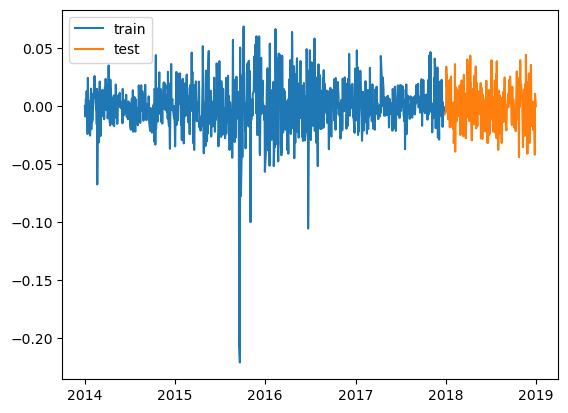

In [35]:
fig, ax = plt.subplots()

ax.plot(days_train, ret_train, label="train")
ax.plot(days_test, ret_test, label="test")
ax.legend()
plt.show()

### Create train set

In [51]:
LOOK_BACK = 20
FORECAST_HORIZON = 1

X_train, y_train = split_sequence(ret_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_HORIZON)
X_train = X_train.reshape(len(X_train), LOOK_BACK, FORECAST_HORIZON)
y_train = y_train.reshape(len(y_train))

### Define model

In [57]:
model1 = Sequential()
model1.add(
    Conv1D(
        filters=64,
        kernel_size=3,
        activation="relu",
        input_shape=(LOOK_BACK, FORECAST_HORIZON)
    )
)
model1.add(
    MaxPooling1D(pool_size=2)
)
model1.add(Flatten())
model1.add(
    Dense(
        50,
        activation="relu"
    )
)
model1.add(Dense(1))

model1.compile(optimizer="adam", loss="mse")

In [60]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 18, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 50)                28850     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 29157 (113.89 KB)
Trainable params: 29157 (113.89 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [62]:
history = model1.fit(X_train, y_train, epochs=10)

Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 4.4068e-04
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 4.4271e-04
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 4.2274e-04
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 4.2142e-04
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 4.1262e-04
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 4.1221e-04
Epoch 7/10
32/32 [==============================] - 0s 4ms/step - loss: 4.0309e-04
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 3.8131e-04
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 3.9871e-04
Epoch 10/10
32/32 [==============================] - 0s 2ms/step - loss: 3.7574e-04


In [ ]:
from